#이미지 증강

In [ ]:
#flip #rotate

#성능지표 (SAD, MSE, MAD, Gradient, Connectivity)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#2차원 값으로 구성된 이미지들간의 차이

"""
Bridging Composite and Real: Towards End-to-end Deep Image Matting [IJCV-2021]
Evaluation files for training and testing.

Copyright (c) 2021, Jizhizi Li (jili8515@uni.sydney.edu.au)
Licensed under the MIT License (see LICENSE for details)
Github repo: https://github.com/JizhiziLi/GFM
Paper link (Arxiv): https://arxiv.org/abs/2010.16188

"""

import numpy as np
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import torch.nn.functional as fnn

##########################
### 성능평가지표: SAD, MSE, Gradient, Connectivity
###code from https://github.com/JizhiziLi/GFM/blob/master/core/evaluate.py
##########################

"""
def calculate_sad_mse_mad(predict_old,alpha,trimap):
	predict = np.copy(predict_old)
	pixel = float((trimap == 128).sum())
	predict[trimap == 255] = 1.
	predict[trimap == 0  ] = 0.
	sad_diff = np.sum(np.abs(predict - alpha))/1000
	if pixel==0:
		pixel = trimap.shape[0]*trimap.shape[1]-float((trimap==255).sum())-float((trimap==0).sum())
	mse_diff = np.sum((predict - alpha) ** 2)/pixel
	mad_diff = np.sum(np.abs(predict - alpha))/pixel
	return sad_diff, mse_diff, mad_diff
	"""
"""
def calculate_sad_mse_mad_whole_img(predict, alpha):
	pixel = predict.shape[0]*predict.shape[1]
	sad_diff = np.sum(np.abs(predict - alpha))/1000
	mse_diff = np.sum((predict - alpha) ** 2)/pixel
	mad_diff = np.sum(np.abs(predict - alpha))/pixel
	return sad_diff, mse_diff, mad_diff
"""

def calculate_sad_mse_mad_whole_img(predict, gt):
	pixel = predict.shape[0]*predict.shape[1]
	sad_diff = np.sum(np.abs(predict - gt))/1000
	mse_diff = np.sum((predict - gt) ** 2)/pixel
	mad_diff = np.sum(np.abs(predict - gt))/pixel
	return sad_diff, mse_diff, mad_diff

"""
def calculate_sad_fgbg(predict, alpha, trimap):
	sad_diff = np.abs(predict-alpha)
	weight_fg = np.zeros(predict.shape)
	weight_bg = np.zeros(predict.shape)
	weight_trimap = np.zeros(predict.shape)
	weight_fg[trimap==255] = 1.
	weight_bg[trimap==0  ] = 1.
	weight_trimap[trimap==128  ] = 1.
	sad_fg = np.sum(sad_diff*weight_fg)/1000
	sad_bg = np.sum(sad_diff*weight_bg)/1000
	sad_trimap = np.sum(sad_diff*weight_trimap)/1000
	return sad_fg, sad_bg
	"""

def compute_gradient_whole_image(pd, gt):
	from scipy.ndimage import gaussian_filter

	pd_x = gaussian_filter(pd, sigma=1.4, order=[1, 0], output=np.float32)
	pd_y = gaussian_filter(pd, sigma=1.4, order=[0, 1], output=np.float32)
	gt_x = gaussian_filter(gt, sigma=1.4, order=[1, 0], output=np.float32)
	gt_y = gaussian_filter(gt, sigma=1.4, order=[0, 1], output=np.float32)
	pd_mag = np.sqrt(pd_x**2 + pd_y**2)
	gt_mag = np.sqrt(gt_x**2 + gt_y**2)

	error_map = np.square(pd_mag - gt_mag)
	loss = np.sum(error_map) / 10
	return loss

def compute_connectivity_loss_whole_image(pd, gt, step=0.1):
	from scipy.ndimage import morphology
	from skimage.measure import label, regionprops
	h, w = pd.shape
	thresh_steps = np.arange(0, 1.1, step)
	l_map = -1 * np.ones((h, w), dtype=np.float32)
	lambda_map = np.ones((h, w), dtype=np.float32)
	for i in range(1, thresh_steps.size):
		pd_th = pd >= thresh_steps[i]
		gt_th = gt >= thresh_steps[i]
		label_image = label(pd_th & gt_th, connectivity=1)
		cc = regionprops(label_image)
		size_vec = np.array([c.area for c in cc])
		if len(size_vec) == 0:
			continue
		max_id = np.argmax(size_vec)
		coords = cc[max_id].coords
		omega = np.zeros((h, w), dtype=np.float32)
		omega[coords[:, 0], coords[:, 1]] = 1
		flag = (l_map == -1) & (omega == 0)
		l_map[flag == 1] = thresh_steps[i-1]
		dist_maps = morphology.distance_transform_edt(omega==0)
		dist_maps = dist_maps / dist_maps.max()
	l_map[l_map == -1] = 1
	d_pd = pd - l_map
	d_gt = gt - l_map
	phi_pd = 1 - d_pd * (d_pd >= 0.15).astype(np.float32)
	phi_gt = 1 - d_gt * (d_gt >= 0.15).astype(np.float32)
	loss = np.sum(np.abs(phi_pd - phi_gt)) / 1000
	return loss

In [ ]:
#4차원 값으로 구성된 이미지들(R,G,B,alpha channel)간의 차이

"""
Bridging Composite and Real: Towards End-to-end Deep Image Matting [IJCV-2021]
Evaluation files for training and testing.

Copyright (c) 2021, Jizhizi Li (jili8515@uni.sydney.edu.au)
Licensed under the MIT License (see LICENSE for details)
Github repo: https://github.com/JizhiziLi/GFM
Paper link (Arxiv): https://arxiv.org/abs/2010.16188

"""

import numpy as np
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import torch.nn.functional as fnn

##########################
### 성능평가지표: SAD, MSE, Gradient, Connectivity
###code from https://github.com/JizhiziLi/GFM/blob/master/core/evaluate.py
##########################

"""
def calculate_sad_mse_mad(predict_old,alpha,trimap):
	predict = np.copy(predict_old)
	pixel = float((trimap == 128).sum())
	predict[trimap == 255] = 1.
	predict[trimap == 0  ] = 0.
	sad_diff = np.sum(np.abs(predict - alpha))/1000
	if pixel==0:
		pixel = trimap.shape[0]*trimap.shape[1]-float((trimap==255).sum())-float((trimap==0).sum())
	mse_diff = np.sum((predict - alpha) ** 2)/pixel
	mad_diff = np.sum(np.abs(predict - alpha))/pixel
	return sad_diff, mse_diff, mad_diff
	"""
"""
def calculate_sad_mse_mad_whole_img(predict, alpha):
	pixel = predict.shape[0]*predict.shape[1]
	sad_diff = np.sum(np.abs(predict - alpha))/1000
	mse_diff = np.sum((predict - alpha) ** 2)/pixel
	mad_diff = np.sum(np.abs(predict - alpha))/pixel
	return sad_diff, mse_diff, mad_diff
"""

def calculate_sad_mse_mad_whole_img(predict, gt):
    pixel = predict.shape[0] * predict.shape[1]
    sad_diff = np.sum(np.abs(predict[:, :, :3] - gt[:, :, :3])) / 1000  # Consider only RGB channels for SAD calculation
    mse_diff = np.sum((predict[:, :, :3] - gt[:, :, :3]) ** 2) / pixel
    mad_diff = np.sum(np.abs(predict[:, :, :3] - gt[:, :, :3])) / pixel
    return sad_diff, mse_diff, mad_diff

def compute_gradient_whole_image(pd, gt):
    from scipy.ndimage import gaussian_filter
    """
    pd_x = gaussian_filter(pd[:, :, :3], sigma=1.4, order=[1, 0], output=np.float32)
    pd_y = gaussian_filter(pd[:, :, :3], sigma=1.4, order=[0, 1], output=np.float32)
    gt_x = gaussian_filter(gt[:, :, :3], sigma=1.4, order=[1, 0], output=np.float32)
    gt_y = gaussian_filter(gt[:, :, :3], sigma=1.4, order=[0, 1], output=np.float32)
    """

    pd_x = gaussian_filter(pd[:, :, :3], sigma=1.4, order=[1, 0, 0], output=np.float32)
    pd_y = gaussian_filter(pd[:, :, :3], sigma=1.4, order=[0, 1, 0], output=np.float32)
    gt_x = gaussian_filter(gt[:, :, :3], sigma=1.4, order=[1, 0, 0], output=np.float32)
    gt_y = gaussian_filter(gt[:, :, :3], sigma=1.4, order=[0, 1, 0], output=np.float32)


    pd_mag = np.sqrt(pd_x**2 + pd_y**2)
    gt_mag = np.sqrt(gt_x**2 + gt_y**2)

    error_map = np.square(pd_mag - gt_mag)
    loss = np.sum(error_map) / 10
    return loss

"""
def calculate_sad_fgbg(predict, alpha, trimap):
	sad_diff = np.abs(predict-alpha)
	weight_fg = np.zeros(predict.shape)
	weight_bg = np.zeros(predict.shape)
	weight_trimap = np.zeros(predict.shape)
	weight_fg[trimap==255] = 1.
	weight_bg[trimap==0  ] = 1.
	weight_trimap[trimap==128  ] = 1.
	sad_fg = np.sum(sad_diff*weight_fg)/1000
	sad_bg = np.sum(sad_diff*weight_bg)/1000
	sad_trimap = np.sum(sad_diff*weight_trimap)/1000
	return sad_fg, sad_bg
	"""


def compute_connectivity_loss_whole_image(pd, gt, step=0.1):
    from scipy.ndimage import morphology
    from skimage.measure import label, regionprops

    h, w, _ = pd.shape
    thresh_steps = np.arange(0, 1.1, step)
    l_map = -1 * np.ones((h, w), dtype=np.float32)
    lambda_map = np.ones((h, w), dtype=np.float32)

    for i in range(1, thresh_steps.size):
        pd_th = pd[:, :, 3] >= thresh_steps[i]  # Thresholding based on the alpha channel
        gt_th = gt[:, :, 3] >= thresh_steps[i]  # Thresholding based on the alpha channel

        label_image = label(pd_th & gt_th, connectivity=1)
        cc = regionprops(label_image)

        size_vec = np.array([c.area for c in cc])
        if len(size_vec) == 0:
            continue

        max_id = np.argmax(size_vec)
        coords = cc[max_id].coords

        omega = np.zeros((h, w), dtype=np.float32)
        omega[coords[:, 0], coords[:, 1]] = 1

        flag = (l_map == -1) & (omega == 0)
        l_map[flag] = thresh_steps[i-1]

        dist_maps = morphology.distance_transform_edt(omega == 0)
        dist_maps = dist_maps / dist_maps.max()

    l_map[l_map == -1] = 1
    d_pd = pd[:, :, 3] - l_map
    d_gt = gt[:, :, 3] - l_map

    phi_pd = 1 - d_pd * (d_pd >= 0.15).astype(np.float32)
    phi_gt = 1 - d_gt * (d_gt >= 0.15).astype(np.float32)

    loss = np.sum(np.abs(phi_pd - phi_gt)) / 1000
    return loss

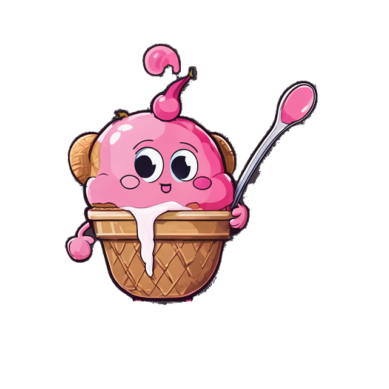

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

pd = Image.open('/content/a cartoon character holding a spoon with a scoop of ice cream in it.png') #predict image의 mask
gt = Image.open('/content/a_cartoon_character_holding_a_spoon_with_a_scoop_of_ice_cream_in_it-removebg-preview.png') #ground truth image의 mask

from PIL import Image
import numpy as np


# Convert the image to a NumPy array
pd_arr = np.array(pd)
gt_arr = np.array(gt)

resized_pd = pd.resize((500, 500))

resized_pd_array = np.array(resized_pd)

sad_diff, mse_diff, mad_diff=calculate_sad_mse_mad_whole_img(resized_pd_array, gt_arr)
grad = compute_gradient_whole_image(resized_pd_array, gt_arr)
connectivity = compute_connectivity_loss_whole_image(resized_pd_array, gt_arr, step=0.1)


In [ ]:
sad_diff

25073.889

In [ ]:
mse_diff

46.038204

In [ ]:
mad_diff

100.295556

In [ ]:
grad

3617705.6

In [ ]:
connectivity

4271.827

#input 폴더, groundtruth 폴더에 있는 것 한번에 계산하기(각각 이름은 같음) -> csv파일에 저장

In [ ]:
import os
from PIL import Image
import numpy as np

def process_image(input_path):
    # Open the image
    img = Image.open(input_path)

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Resize the image
    resized_img = img.resize((500, 500))

    # Convert the resized image to a NumPy array
    resized_img_array = np.array(resized_img)

    return resized_img_array

# Input and output directories
predicted_directory = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_sam_hq_vit' #수정
groundtruth_directory = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/sam_test/output/gt' #수정
#output_directory = '/content/output_images/'

# List of file names in input and ground truth directories
predicted_files = os.listdir(predicted_directory)
gt_files = os.listdir(groundtruth_directory)

# Lists to store output values and file names
sad_values = []
mse_values = []
mad_values = []
gradient_values = []
connectivity_values = []
output_file_names = []

# Process each input file
for file_name in predicted_files:
    print('filename', file_name)
    # Construct full paths for input and ground truth images
    input_path = os.path.join(predicted_directory, file_name)
    gt_path = os.path.join(groundtruth_directory, file_name)

    # Check if corresponding ground truth file exists
    if file_name in gt_files:
        # Process the images
        resized_array = process_image(input_path)
        gt_array = process_image(gt_path)

        # Perform calculations
        sad, mse, mad = calculate_sad_mse_mad_whole_img(resized_array, gt_array)
        grad = compute_gradient_whole_image(resized_array, gt_array)
        conn = compute_connectivity_loss_whole_image(resized_array, gt_array, step=0.1)

        # Store the values and file names
        sad_values.append(sad)
        mse_values.append(mse)
        mad_values.append(mad)
        gradient_values.append(grad)
        connectivity_values.append(conn)
        output_file_names.append(file_name)

# Save the values to a local file or perform further analysis
# For example, saving the values to a CSV file
import csv

output_file = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/sam_test/output/sam_hq_vit_calculated_results.csv'  # 수정

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'SAD', 'MSE', 'MAD', 'Gradient', 'Connectivity'])

    for i in range(len(output_file_names)):
        writer.writerow([
            output_file_names[i],
            sad_values[i],
            mse_values[i],
            mad_values[i],
            gradient_values[i],
            connectivity_values[i]
        ])

filename A Rubik's Cube, with Earth intricately drawn on each face, which is not solved yet, placed on a clean white background.png


<ipython-input-2-96882e7376d6>:122: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  dist_maps = morphology.distance_transform_edt(omega == 0)


filename A robot standing front view, photo by wes anderson-ai-generated-flamel.png
filename a cartoon character holding a spoon with a scoop of ice cream in it(1).png
filename a cartoon character holding a spoon with a scoop of ice cream in it(2).png
filename a cartoon character holding a spoon with a scoop of ice cream in it(3).png
filename a cartoon character holding a spoon with a scoop of ice cream in it.png
filename a white disc on the floor.png
filename an image of a Rubik's Cube.png
filename 경양식 돈까스-ai-generated-flamel.png
filename 귀여운 보라색 요정-ai-generated-flamel.png
filename 노란색 귀여운 소파-ai-generated-flamel.png
filename 보라색 목도리를 한 귀여운 눈사람 캐릭터.png
filename 보라색 목도리를 한 귀여운 눈사람-ai-generated-flamel.png
filename 빈티지한 의자-ai-generated-flamel.png
filename 초록색 반짝이는 포장지로 싸이고 빨간색 끈으로 리본이 묶인 선물 박스-ai-generated-flamel.png
filename 크리스마스 케익-ai-generated-flam

In [ ]:
len(sad_values)

14

In [ ]:
#drive파일 이름 변경
"""
import os

input_path = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matte_anything_samhq"
output_path = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matte_anything_samhq"


input_file = "a rubik's code and a tree.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "A Rubik's Cube, with Earth intricately drawn on each face, which is not solved yet, placed on a clean white background.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a robot in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "A robot standing front view, photo by wes anderson-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cartoon character in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "a cartoon character holding a spoon with a scoop of ice cream in it(1).png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cartoon character in the middle2.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "a cartoon character holding a spoon with a scoop of ice cream in it(2).png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cartoon character in the middle3.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "a cartoon character holding a spoon with a scoop of ice cream in it(3).png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cartoon character in the middle4.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "a cartoon character holding a spoon with a scoop of ice cream in it.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a white disc on the floor.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "a white disc on the floor.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a Rubik's cube.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "an image of a Rubik's Cube.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a plate of port food in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "경양식 돈까스-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cute fairtale in the middle1.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "귀여운 보라색 요정-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a yellow sofa in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "노란색 귀여운 소파-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a snowman with the purple scarf1.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "보라색 목도리를 한 귀여운 눈사람 캐릭터.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a snowman with the purple scarf2.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "보라색 목도리를 한 귀여운 눈사람-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a chair in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "빈티지한 의자-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a present in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "초록색 반짝이는 포장지로 싸이고 빨간색 끈으로 리본이 묶인 선물 박스-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)

input_file = "a cake in the middle.png"
input_path_final = os.path.join(input_path, input_file)
output_file = "크리스마스 케익-ai-generated-flamel.png"
output_path_final = os.path.join(output_path, output_file)
os.rename(input_path_final, output_path_final)
"""

## clip score (input prompt <-> background removed image)

In [ ]:
!pip install torch
!pip install git+https://github.com/openai/CLIP.git
!pip install clip-score

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6ckt_j_b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6ckt_j_b
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 826.2 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=3066d6f97566f679a89d56358c26fd252e5ea3244819e17d1fbc8d53f93991fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfdgkat0/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Preparing metadata (setup.py) ... done
  Created wheel for clip-score: filename=clip_score-0.1.1-py3-none-any.whl size=9990 sha256=db494650bd99652a7d8e0e72793594ed3ae2ffa4622b52daa940260203cc7737
  Stored in directory: /root/.cache/pip/wheels/b0/46/91/97ba1991d5b82799cec6179218336517e892

In [ ]:
image_path = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matting_anything/A Rubiks Cube, with Earth intricately drawn on each face, which is not solved yet, placed on a clean white background.png"
text_path = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test_etc/output/input_prompt/a rubik's code and a tree.txt"

!python -m clip_score "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test_etc/output/test/" "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test_etc/output/input_prompt/"


Loading CLIP model: ViT-B/32
Calculating CLIP Score:
100% 1/1 [00:01<00:00,  1.84s/it]
CLIP Score:  35.20554733276367


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install -U torch torchvision
!pip install -U git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 619.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hzuio4xo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hzuio4xo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import clip
from PIL import Image

def get_clip_score(image_path, text):
# Load the pre-trained CLIP model and the image
  model, preprocess = clip.load('ViT-B/32')
  image = Image.open(image_path)

  # Preprocess the image and tokenize the text
  image_input = preprocess(image).unsqueeze(0)
  text_input = clip.tokenize([text])

  # Move the inputs to GPU if available
  device = "cuda" if torch.cuda.is_available() else "cpu"
  image_input = image_input.to(device)
  text_input = text_input.to(device)
  model = model.to(device)

  # Generate embeddings for the image and text
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_input)

  # Normalize the features
  image_features = image_features / image_features.norm(dim=-1, keepdim=True)
  text_features = text_features / text_features.norm(dim=-1, keepdim=True)

  # Calculate the cosine similarity to get the CLIP score
  clip_score = torch.matmul(image_features, text_features.T).item()

  return clip_score


In [ ]:
import csv
from natsort import natsorted

# Define the folder containing images and the list of texts
image_folder = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matte_anything_samhq"
text_list = ["a rubik's code and a tree",
'a robot in the middle',
'a cartoon character in the middle',
'a cartoon character in the middle2',
'a cartoon character in the middle3',
'a cartoon character in the middle4',
'a white disc on the floor',
"a Rubik's cube",
'a plate of port food in the middle',
'a cute fairtale in the middle1',
'a yellow sofa in the middle',
'a snowman with the purple scarf1',
'a snowman with the purple scarf2',
'a chair in the middle',
'a present in the middle',
'a cake in the middle']

csv_filename = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test_etc/matte_any_samhq_clip.csv'  # Name of the CSV file
clip_scr = []  # List to store CLIP scores

# Pair each image with corresponding text  ,natsorted(files)
for image_path, text in zip(natsorted(os.listdir(image_folder)), text_list):
    print("image:",image_path)
    print("text:",text)
    if image_path.endswith(".png"):  # Ensure the file is a PNG image
        image_path = os.path.join(image_folder, image_path)
        score = get_clip_score(image_path, text)
        clip_scr.append([image_path, text, score])

# Write the data to a CSV file
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Path', 'Text', 'CLIP Score'])  # Write header
    for row in clip_scr:
        writer.writerow(row)

print(f'Data has been saved to {csv_filename}')

image: A Rubik's Cube, with Earth intricately drawn on each face, which is not solved yet, placed on a clean white background.png
text: a rubik's code and a tree
image: A robot standing front view, photo by wes anderson-ai-generated-flamel.png
text: a robot in the middle
image: a cartoon character holding a spoon with a scoop of ice cream in it(1).png
text: a cartoon character in the middle
image: a cartoon character holding a spoon with a scoop of ice cream in it(2).png
text: a cartoon character in the middle2
image: a cartoon character holding a spoon with a scoop of ice cream in it(3).png
text: a cartoon character in the middle3
image: a cartoon character holding a spoon with a scoop of ice cream in it.png
text: a cartoon character in the middle4
image: a white disc on the floor.png
text: a white disc on the floor
image: an image of a Rubik's Cube.png
text: a Rubik's cube
image: 경양식 돈까스-ai-generated-flamel.png
text: a plate of port food in the middle
image: 귀여운 보라색